# Exploratory work on Siamese convolutional networks for miniproject 1

### What is a siamese network?
A network that has two identical datapaths through weight sharing.

### Importing libs

In [1]:
import torch
from torch import nn as nn
from torch import functional as F
from matplotlib import pyplot as plt
import pandas as pd
import DL_project_utils as utils
from ray import tune
from ray.tune.schedulers import ASHAScheduler


%load_ext autoreload
%autoreload 1
%aimport DL_project_utils

C:\ProgramData\Anaconda3\envs\DeepLearning\lib\site-packages\ray\autoscaler\_private\cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  "update your install command.", FutureWarning)


### Defining the model

In [27]:
class SiameseNet1(nn.Module):
    def __init__(self):
        super().__init__()
        self.shared_model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(4,4), padding=(3,3)),
            nn.Dropout2d(p=0.3),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=(2,2)),
            nn.Dropout2d(p=0.3),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Flatten(),
            nn.Linear(in_features=1600, out_features=256),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=10),
            nn.Softmax(dim=1)
        )
        self.comparator = nn.Sequential(
            nn.Linear(in_features=20, out_features=2),
            nn.ReLU()
        )


    def forward(self, x):
        num_1 = x[:,0,:,:].unsqueeze(1)
        num_2 = x[:,1,:,:].unsqueeze(1)

        pred_1 = self.shared_model(num_1)
        pred_2 = self.shared_model(num_2)

        return self.comparator(torch.cat((pred_1, pred_2), 1))

In [28]:
class SiameseNet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.shared_model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(4,4), padding=(3,3)),
            nn.Dropout2d(p=0.3),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=(2,2)),
            nn.Dropout2d(p=0.3),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Flatten(),
            nn.Linear(in_features=1600, out_features=256),
            nn.Dropout(p=0.3),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.Dropout(p=0.3),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=10),
            nn.Softmax(dim=1)
        )
        self.comparator = nn.Sequential(
            nn.Linear(in_features=20, out_features=2),
            nn.ReLU()
        )


    def forward(self, x):
        num_1 = x[:,0,:,:].unsqueeze(1)
        num_2 = x[:,1,:,:].unsqueeze(1)

        pred_1 = self.shared_model(num_1)
        pred_2 = self.shared_model(num_2)

        return self.comparator(torch.cat((pred_1, pred_2), 1))

### Training and plotting performance

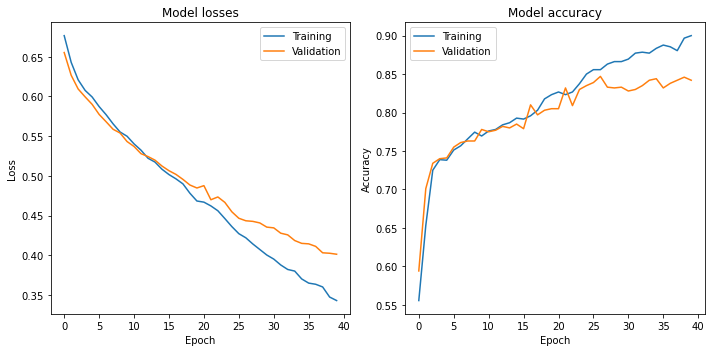

The test data gives an accuracy of 84.3400%


In [32]:
train_data, test_data = utils.read_input(500, single_channel=False, pairs=5000)

epochs, lr, loss, optimizer, batch_size = 40, 2e-3, 'cross_entropy', 'Adam', 500
model = SiameseNet1()
train_loss, train_acc, val_loss, val_acc = utils.train_model(model, train_dataset=train_data, batch_size=batch_size, learning_rate=lr,
                                                             optimizer=optimizer, loss=loss, epochs=epochs,
                                                             verbose=False, cuda=True)

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model losses')
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(122)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

print(f'The test data gives an accuracy of {100*utils.evaluate_model(model, test_data, True, 500):.4f}%')

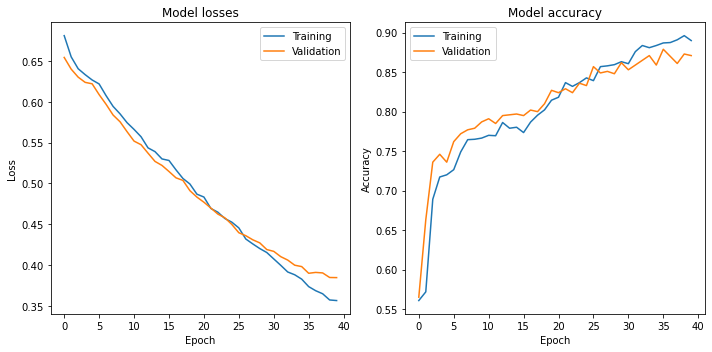

The test data gives an accuracy of 87.0400%


In [23]:
train_data, test_data = utils.read_input(100, single_channel=False, pairs=5000)

epochs, lr, loss, optimizer, batch_size = 40, 2e-3, 'cross_entropy', 'Adam', 500
model = SiameseNet2()
train_loss, train_acc, val_loss, val_acc = utils.train_model(model, train_dataset=train_data, batch_size=batch_size, learning_rate=lr,
                                                             optimizer=optimizer, loss=loss, epochs=epochs,
                                                             verbose=False, cuda=True)

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model losses')
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(122)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

print(f'The test data gives an accuracy of {100*utils.evaluate_model(model, test_data, True, 500):.4f}%')

# Hyperparameter tuning
